In [240]:
import os
import numpy as np
import numpy.ma as ma
from astropy.table import Table
from scipy.optimize import minimize, Bounds
from DRP_rotation_curve import extract_data, extract_Pipe3d_data
from disk_mass import calc_mass_curve, fit_mass_curve
from rotation_fitfunctions import find_phi, parameterfit_iso, parameterfit_NFW, parameterfit_bur, rot_incl_iso, rot_incl_bur, \
rot_incl_NFW
from rotation_curve_functions import disk_bulge_vel, halo_vel_NFW, bulge_vel, disk_vel
import RC_plotting_functions as RC#import plot_diagnostic_panel
import matplotlib.pyplot as plt
%matplotlib inline

In [239]:
import importlib
import rotation_fitfunctions
import rotation_curve_functions
importlib.reload(RC)
importlib.reload(rotation_fitfunctions)
importlib.reload(rotation_curve_functions)

<module 'rotation_curve_functions' from 'C:\\Users\\Lara\\Documents\\rotationcurves\\rotation_curve_functions.py'>

In [3]:
gal_ID = '7443-12705'
H_0 = 100  # Hubble's Constant in units of h km/s/Mpc
c = 299792.458  # Speed of light in units of km/s
fit_function = 'bulge'


In [4]:
MASS_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\pipe3d\v3_1_1\3.1.1\7443"
VEL_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\analysis\v3_1_1\3.1.0\HYB10-MILESHC-MASTARSSP\7443\12705"
DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"

In [5]:
DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"
DRP_table = Table.read( DRP_FILENAME, format='fits')


DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]

    DRP_index[galaxy_ID] = i


In [118]:
maps = extract_data(VEL_MAP_FOLDER,gal_ID,['Ha_vel', 'r_band', 'Ha_flux', 'Ha_sigma'])
sMass_density, sMass_density_err = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)
i_DRP = DRP_index[gal_ID]
axis_ratio = DRP_table['nsa_sersic_ba'][i_DRP]
incl = np.arccos(np.sqrt((axis_ratio**2 - 0.2**2)/1-0.2**2)) 
phi = DRP_table['nsa_elpetro_phi'][i_DRP]
print(axis_ratio)
print(phi)
z = DRP_table['nsa_z'][i_DRP]
print(z)
SN_map = maps['Ha_flux'] * np.sqrt(maps['Ha_flux_ivar'])
map_mask = maps['Ha_vel_mask'] + (SN_map < 5)




maps['vmasked'] = ma.array(maps['Ha_vel'], mask=map_mask)
maps['ivarmasked'] = ma.array(maps['Ha_vel_ivar'], mask=map_mask)

shape = maps['vmasked'].shape
scale = (0.5 * z * c / H_0) * 1000 / 206265  # kpc
center = np.unravel_index(ma.argmax(maps['r_band']), shape)
x_center = center[0]
y_center = center[1]
count = 0
phi = find_phi(center, phi, maps['vmasked'])
param = [incl, phi, x_center, y_center]

1.3432236922176852
36.9388
0.0644735
-9.503156
(37, 37)
0.6447036817356814


In [286]:
ba = np.cos(0.11259096400658039)


finding mass curve
7443-12705 mass curve calculated


C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:387: RuntimeWarning: invalid value encountered in multiply
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:396: RuntimeWarning: invalid value encountered in true_divide
  vb_2 = coeff_2 * F / r
C:\Users\Lara\Documents\rotationcurves\disk_mass_plotting_functions.py:89: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[fit_parameters['Sigma_disk'],
C:\Users\Lara\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


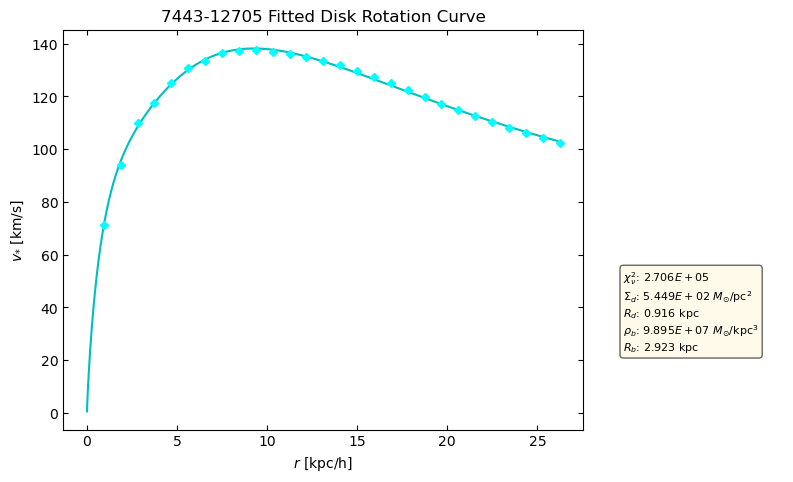

{'Sigma_disk': 544.9013356800971, 'Sigma_disk_err': 9.40607223060667, 'R_disk': 0.9164903335058967, 'R_disk_err': 0.02594943680250392, 'rho_bulge': 98952474.13706602, 'rho_bulge_err': 2069598.0465884472, 'R_bulge': 2.9229266317468823, 'R_bulge_err': 0.021135180760058457, 'chi2_disk': 270560.8855899861}


In [288]:


#0.11259096400658039, 0.7257461163584406, 35.49489300431426, 36.873046417018436
mass_data_table = calc_mass_curve(sMass_density,
                                          sMass_density_err,
                                          maps['r_band'],
                                          map_mask,
                                          35,
                                          36,
                                          axis_ratio,
                                          0.7257461163584406,
                                          z,
                                          gal_ID)
print(gal_ID, "mass curve calculated")
param_outputs = fit_mass_curve(mass_data_table,
                                       gal_ID,
                                       fit_function)
print(param_outputs)


In [291]:
SigD = param_outputs["Sigma_disk"]
Rd = param_outputs["R_disk"]
rho_bulge = param_outputs["rho_bulge"]
R_bulge = param_outputs["R_bulge"]

In [ ]:
best_fit_test = parameterfit_bur(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

In [18]:
best_fit_NFW = parameterfit_NFW(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:229: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(coeff_2 * F / r)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:347: RuntimeWarning: invalid value encountered in double_scalars
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:590: RuntimeWarning: invalid value encountered in double_scalars
  vel2 = G * (halo_mass * Msun) / (r * 3.08E16)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:589: RuntimeWarning: invalid value encountered in log
  halo_mass = 4*np.pi*rho0_h*Rh**3*((-r/(Rh+r)) + np.log(Rh + r) - np.log(Rh))


---------------------------------------------------
   direc: array([[-2.31020053e-15,  2.55722122e-02,  0.00000000e+00,
         2.11215090e-02, -2.78876663e-01, -9.21988336e-01,
        -3.05819485e+00],
       [-1.46518230e-01,  1.01468452e+00,  7.62907444e-03,
        -1.08332288e-02,  2.07978200e-02,  2.43076804e-01,
         2.82519194e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.93818082e-02,  7.73044442e-01,  3.34347082e-03,
         1.22390755e-02,  4.47035262e-01, -2.33127277e-01,
        -2.59229128e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-6.90350899e+00,  5.89531900e+01,  7.11462519e-01,
        -1.4921

In [19]:
best_fit_bur =parameterfit_bur(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:672: RuntimeWarning: invalid value encountered in double_scalars
  vel2 = G * (halo_mass * Msun) / (r * 3.08E16)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:674: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(vel2) / 1000
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:669: RuntimeWarning: invalid value encountered in log
  halo_mass = np.pi * (-rho0_h) * (Rh**3) * (-np.log(Rh**2 + r**2) - 2*np.log(Rh + r) + 2*np.arctan2(r,Rh) + np.log(Rh**2)\
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:670: RuntimeWarning: invalid value encountered in log
  + 2*np.log(Rh) - 2*np.arctan2(0,Rh))


---------------------------------------------------
   direc: array([[-0.1230956 ,  0.39888121,  0.        ,  0.0584556 , -0.27172749,
        -0.85110192,  1.03549347],
       [-0.14294654,  0.40766833,  0.        , -0.00915359,  1.59656528,
         1.89145506,  0.71565364],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [-0.0073258 ,  0.09101814,  0.        ,  0.00317397,  0.03323503,
        -0.15100138, -0.9796037 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.02539412, -0.199684  ,  0.        ,  0.00295798,  0.13579216,
        -0.02873742, -0.5337192 ]])
     fun: 75623.85496380848
 message: 'Optimization terminated successfully.'
    nfev: 2099
     nit: 21
  status: 0
 success: True
       x: array([ 1.11618989,  4.55702666,  0.10

In [292]:
best_fit_iso =parameterfit_iso(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

---------------------------------------------------
   direc: array([[-1.49369188e-01,  1.98784582e-01,  0.00000000e+00,
        -2.17655977e-02,  4.44850017e-01,  3.33664589e-01,
        -1.59142480e+00],
       [-3.05975248e-02,  3.62811076e-02,  0.00000000e+00,
        -2.07004511e-02, -1.00001068e+00, -7.85960779e-01,
        -1.65497543e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.31373077e-15,  6.41251301e-03,  0.00000000e+00,
         2.39997425e-02,  2.91448990e-01, -5.37381874e-01,
        -3.52654648e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-6.04583635e-02,  1.62405987e-01,  2.32025021e-03,
         6.3044

In [49]:



iso_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_iso[0],best_fit_iso[1],best_fit_iso[2],best_fit_iso[3],best_fit_iso[4],best_fit_iso[5],best_fit_iso[6]]
NFW_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_NFW[0],best_fit_NFW[1],best_fit_NFW[2],best_fit_NFW[3],best_fit_NFW[4],best_fit_NFW[5],best_fit_NFW[6]]
bur_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_bur[0],best_fit_bur[1],best_fit_bur[2],best_fit_bur[3],best_fit_bur[4],best_fit_bur[5],best_fit_bur[6]]

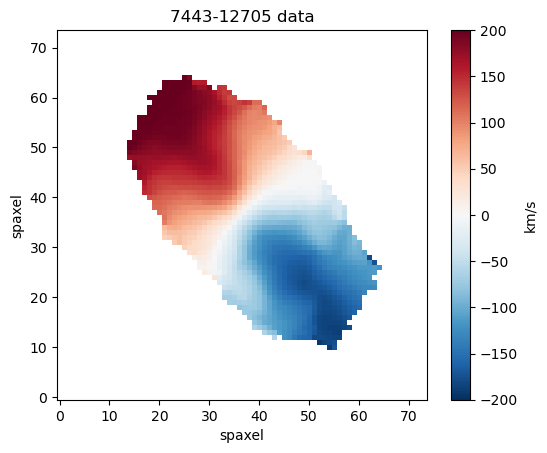

In [21]:
plt.imshow(maps['vmasked'], 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-200, 
           vmax=200)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')
plt.title('7443-12705 data')
plt.savefig("7443-12705_data")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iso: [120050641.10390615, 2.73444270675828, 651.0289797724238, 0.903804192022047, 1.0348425956882457, 2.453408041040089, 0.11259096400658039, 0.7257461163584406, 35.49489300431426, 36.873046417018436, 15.594138225613003]
1650.1750573277013
NFW [120050641.10390615, 2.73444270675828, 651.0289797724238, 0.903804192022047, -5.00265663603556, 57.40952254166348, 1.116267177335428, 0.7117772382184775, 35.65491989182425, 39.25743074468698, 23.872000393112966]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


143.717774717443
Bur: [120050641.10390615, 2.73444270675828, 651.0289797724238, 0.903804192022047, 1.1161898879643106, 4.5570266585743555, 0.10011908850320271, 0.7267460464442463, 35.399667796345, 36.82539883524999, 15.632743812045346]
1782.5595313226358


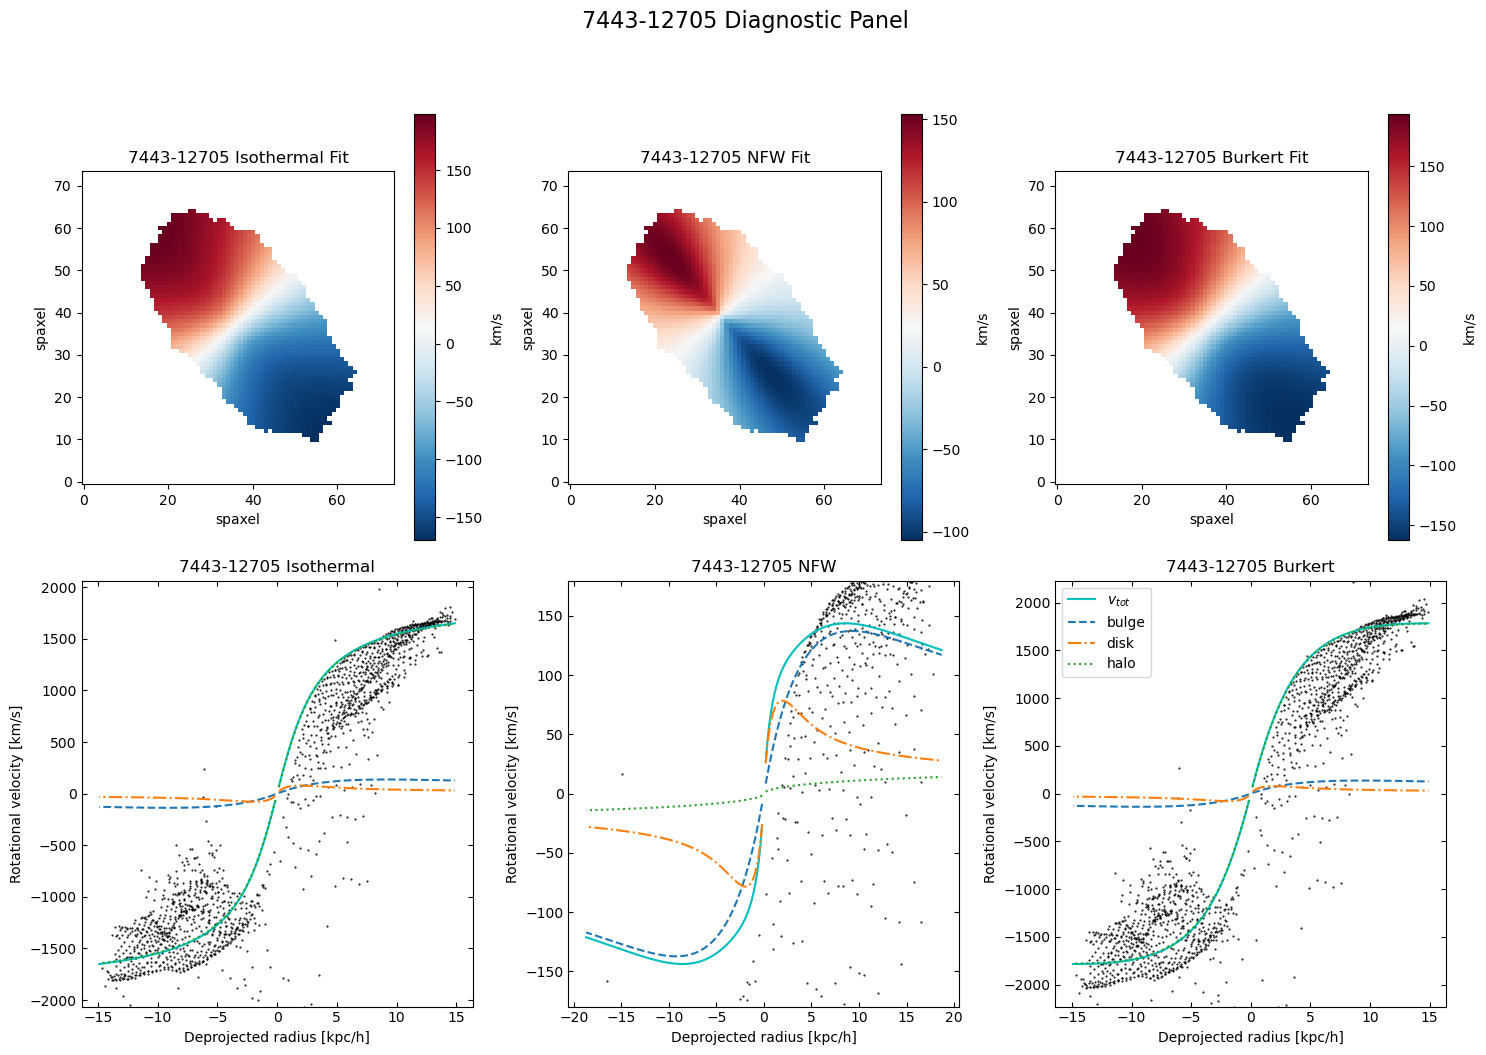

In [77]:
RC.plot_diagnostic_panel(gal_ID, shape, scale, iso_fit, NFW_fit, bur_fit, map_mask, maps['vmasked'],maps['ivarmasked'])


In [98]:
#NFW: -2,35

C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:229: RuntimeWarning: invalid value encountered in true_divide
  vel = np.sqrt(coeff_2 * F / r)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:347: RuntimeWarning: invalid value encountered in multiply
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:505: RuntimeWarning: divide by zero encountered in true_divide
  vel = v_inf * np.sqrt((1 - ((Rh/r)*np.arctan2(r,Rh))))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:505: RuntimeWarning: invalid value encountered in multiply
  vel = v_inf * np.sqrt((1 - ((Rh/r)*np.arctan2(r,Rh))))


796.4281775734773


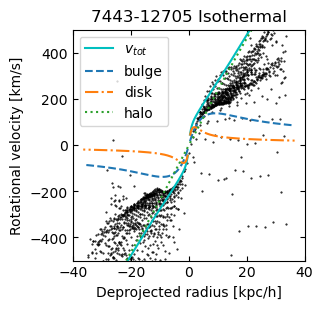

In [289]:
iso_test=[rho_bulge, R_bulge,SigD, Rd, -1.5, 60,incl,phi,37,37,23]
RC.plot_rot_curve(maps['vmasked'],maps['ivarmasked'],iso_test,scale,gal_ID,'Isothermal')
plt.gca().set_ylim(-500,500);
#plt.gca().set_xlim(-15,15);

In [238]:
best_fit_NFW_test = parameterfit_NFW(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

---------------------------------------------------
   direc: array([[-2.31020056e-15,  2.55722132e-02,  0.00000000e+00,
         2.11215095e-02, -2.78876669e-01, -9.21988340e-01,
        -3.05819486e+00],
       [-1.46518242e-01,  1.01468465e+00,  7.62907524e-03,
        -1.08332302e-02,  2.07977732e-02,  2.43076818e-01,
         2.82519350e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.93818198e-02,  7.73044559e-01,  3.34347120e-03,
         1.22390749e-02,  4.47035308e-01, -2.33127258e-01,
        -2.59229142e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-6.90350896e+00,  5.89531930e+01,  7.11462504e-01,
        -1.4921

[14.36313883 14.12434157 13.87175184 13.60413557 13.32008313 13.01797202
 12.69591851 12.35171395 11.98273901 11.58584588 11.15719202 10.69199846
 10.18418527  9.62579745  9.00604968  8.30962275  7.51333112  6.57870147
  5.43181063  3.88467883         nan  3.88467883  5.43181063  6.57870147
  7.51333112  8.30962275  9.00604968  9.62579745 10.18418527 10.69199846
 11.15719202 11.58584588 11.98273901 12.35171395 12.69591851 13.01797202
 13.32008313 13.60413557 13.87175184 14.12434157]
